In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import _autolag
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import seaborn as sns
#sns.set_theme()
#from scipy.stats import pearsonr

DATA PREPARATION

In [2]:
data_df=pd.read_excel('Gas Data processed.xlsx',sheet_name="code_monthly_deflated")
df=data_df.loc[1:120,["months", "price_gas", "price_brent_gbp","open_interest_gas","lng","storage","temperature","euas","supply","coal_gbp","eurgbp","gbpusd"]] 
print(df)

#first ets value at line 38

     months  price_gas  price_brent_gbp  open_interest_gas       lng  \
1    Nov 09  33.794286        53.233565            13795.0  1.270000   
2    Dec 09  38.318182        52.288674            12590.0  1.670000   
3    Jan 10  44.157175        54.302797            13650.0  1.540000   
4    Feb 10  35.532880        55.081704            12720.0  1.330000   
5    Mar 10  33.494927        58.531509            18530.0  1.320000   
..      ...        ...              ...                ...       ...   
116  Jun 19  23.772011        46.879426            54235.0  0.401961   
117  Jul 19  27.581094        48.710726            53705.0  0.394550   
118  Aug 19  30.470480        44.794155            70397.0  0.263035   
119  Sep 19  39.797235        47.105697           101360.0  0.928689   
120  Oct 19  39.372114        42.733717            92295.0  1.880457   

      storage  temperature     euas     supply   coal_gbp   eurgbp    gbpusd  
1   -0.060000        10.00  11.1690   8.150000  53.71270

In [3]:
#Vector:
dprice_gas=df.price_gas
dprice_brent_gbp=df.price_brent_gbp
dOI=df.open_interest_gas
dtemp=df.temperature
dstore=df.storage
dlng=df.lng
dsupply=df.supply
dEUAs=df.euas
dEUR=df.eurgbp
dUSD=df.gbpusd
dcoal=df.coal_gbp

time= df.months
#DataSeries=[dprice_gas,dprice_brent_gbp,dcoal,dOI,dEUAs,dUSD]
DataSeries=[dprice_gas,dsupply, dlng, dstore, dtemp]

#DataSeries=[dprice_gas,dprice_brent_usd,dOI,dstore,dlng,dtemp,dsupply,dEUAs]
df_test = pd.concat(DataSeries,axis=1)

In [4]:
######### INITIAL DATA TESTS #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary

from statsmodels.tsa.stattools import adfuller, kpss
######## NORMALITY TEST V2 ########

def normality_test_matrix(data, variables, test):    
    """Check normality test to comply with general model assumptions.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    test      : type of test to perform
    """

    col=['test statistic ','p-value ', 'lags used ']
    df = pd.DataFrame(np.zeros((len(variables), 3)), columns=col, index=variables)
    for r in df.index:
        if test == "Dickey-Fuller":
            dftestdickey = adfuller(data[r].values, autolag='AIC')
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestdickey[c]           
        elif test == "KPSS":
            dftestkpss = kpss(data[r].values, regression='c', nlags="auto")
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestkpss[c]

    print("Results for "+test+" test")
    df.columns = [var + test for var in col]

    #df.index = [var for var in variables]s
    return df


### styles ###

def highlight_cells_DF(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e < 0.05 else highlight_false for e in series]  

def highlight_cells_KPSS(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e > 0.05 else highlight_false for e in series]  


dfdifull = normality_test_matrix(df_test, variables = df_test.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)

Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
price_gas,-2.350232,0.156278,4.000000
price_brent_gbp,-1.171915,0.685559,0.000000
coal_gbp,-1.813593,0.373735,2.000000
open_interest_gas,-0.830038,0.810139,2.000000
euas,0.012306,0.959538,0.000000
gbpusd,-1.271754,0.641994,0.000000


In [5]:
dfkpss = normality_test_matrix(df_test, variables = df_test.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range

,test statistic KPSS,p-value KPSS,lags used KPSS
price_gas,0.563337,0.027402,6.000000
price_brent_gbp,0.971438,0.010000,6.000000
coal_gbp,0.485612,0.044907,6.000000
open_interest_gas,1.934457,0.010000,5.000000
euas,1.344918,0.010000,6.000000
gbpusd,1.359843,0.010000,6.000000


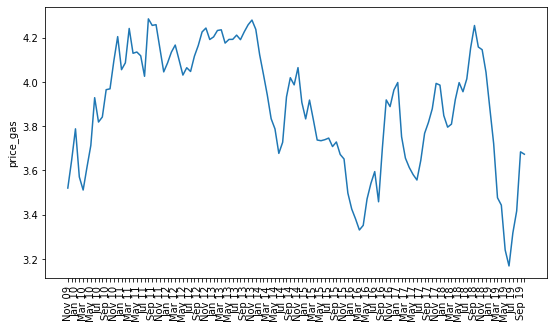

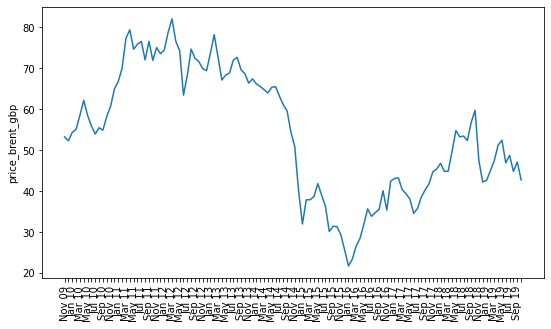

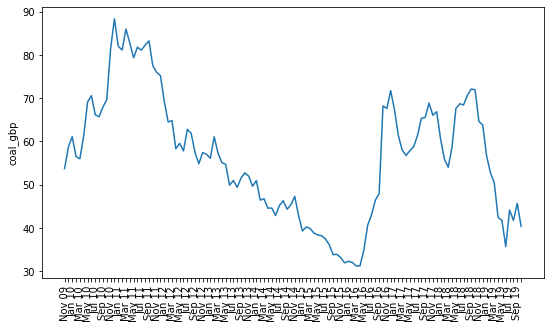

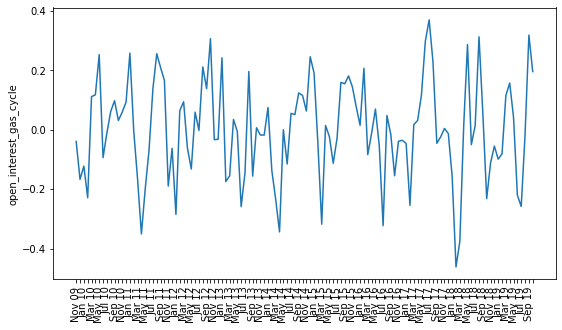

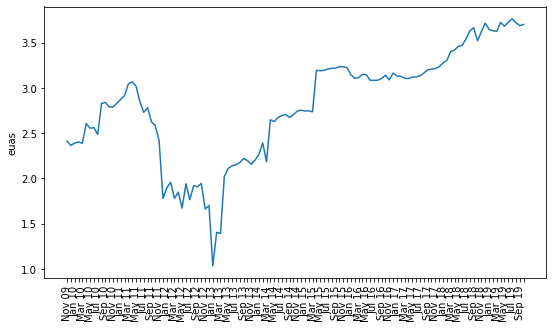

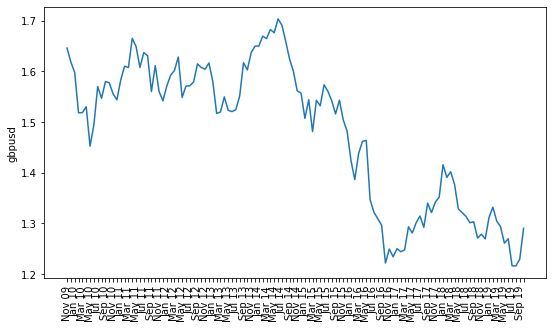

In [6]:
######### DATA CORRECTION #########
#ideally, for each set, apply specific changes
# detrending for linear processes
# differences for random walks 
# other ? non linear processes

#### differentiate 1
DataSeriesCorr=[]
for df in DataSeries:
    if df.name in ["price_brent_usd","euas","open_interest_gas","lng","price_gas"] :
        df_log = pd.Series(np.log(df))
        df = df_log
    #if df.name == "price_gas":
    #    df_diff=df[2:]
    if df.name == "open_interest_gas":
        cycle, trend = sm.tsa.filters.hpfilter(df, 1600)
        #plt.plot(trend)
        #plt.plot(cycle)
        #plt.plot(trend+cycle)
        df=cycle

    else:
        pass
    #df_diff = df.diff().dropna()

    plt.figure(figsize=(9, 5))
    plt.plot(time, df)
    plt.ylabel(df.name)
    ax = plt.gca()
    plt.xticks(rotation=90)
    for label in ax.get_xaxis().get_ticklabels()[1::2]:
        label.set_visible(False)
    plt.show()
    DataSeriesCorr.append(df)




df_corr = pd.concat(DataSeriesCorr,axis=1)




In [7]:
######### STATIONARITY DATA TEST #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary


dfdifull = normality_test_matrix(df_corr, variables = df_corr.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)


Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
price_gas,-2.570635,0.099220,4.000000
price_brent_gbp,-1.171915,0.685559,0.000000
coal_gbp,-1.813593,0.373735,2.000000
open_interest_gas_cycle,-6.409386,0.000000,4.000000
euas,-1.050517,0.734397,2.000000
gbpusd,-1.271754,0.641994,0.000000


In [8]:
dfkpss = normality_test_matrix(df_corr, variables = df_corr.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range

,test statistic KPSS,p-value KPSS,lags used KPSS
price_gas,0.553997,0.029505,6.000000
price_brent_gbp,0.971438,0.010000,6.000000
coal_gbp,0.485612,0.044907,6.000000
open_interest_gas_cycle,0.022217,0.100000,3.000000
euas,1.162356,0.010000,6.000000
gbpusd,1.359843,0.010000,6.000000


In [9]:
#### EXPORT NORMALISED DATA ####
df_corr.to_excel(r'export_normal_data.xlsx', index = False)

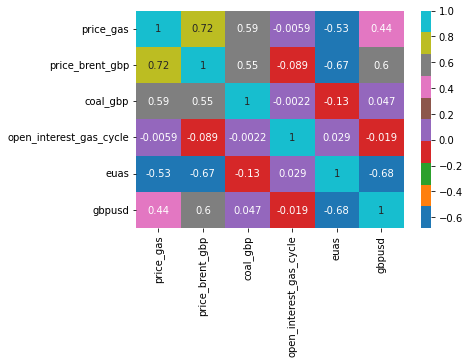

In [10]:
#### CORRELATION MATRIX ####

corrM=df_corr.corr()
#plt.imshow(corrM, cmap='hot', interpolation='nearest')
#plt.show()
ax=sns.heatmap(corrM, annot=True, cmap="tab10")


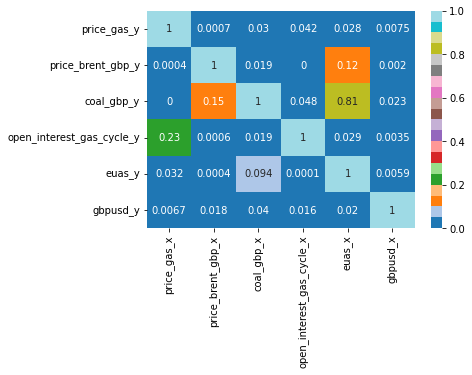

In [11]:
#### CORRECTED GRANGER CAUSALITY ####

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=15
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    #plot
    sns.heatmap(df, annot=True, cmap="tab20")
    #return df


##### actual test
grangers_causation_matrix(df_corr, variables = df_corr.columns)        


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


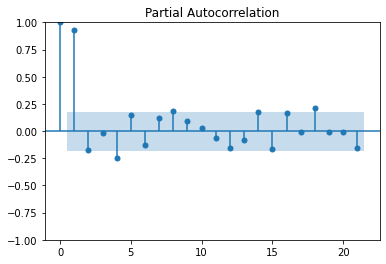

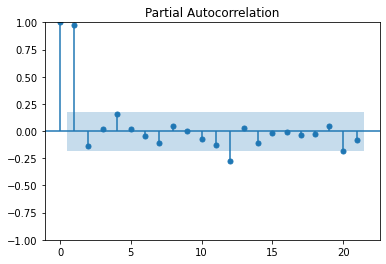

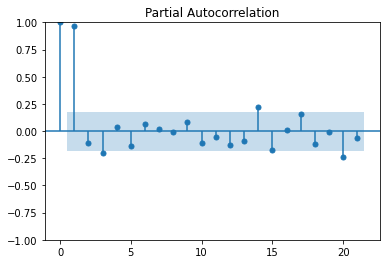

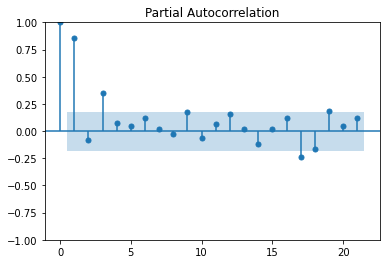

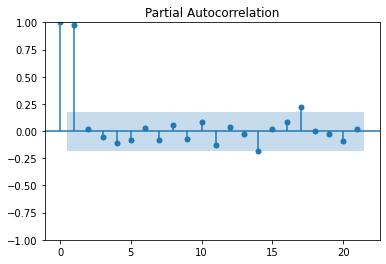

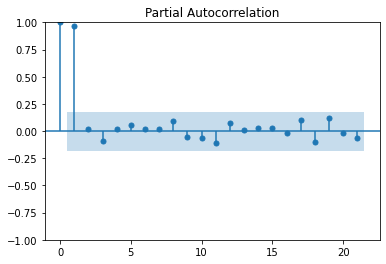

In [12]:
######### LAG LENGTH CRITERIA ######### either multiple of frequency or Schwarz, akaike, hannan-quinn, bayesian 

for df in DataSeries:
    plot_pacf(df)
    plt.show()

# for df in DataSeries:
#     lag_selection = _autolag(mod=VAR,endog=df, exog=df, startlag=1, maxlag=30, method="aic")
#     lag_selection.results()
#     #plt.show()


In [13]:
##### MODEL FITTING #####

model = VAR(df_corr)
x = model.select_order()
x.summary()
#model_fit = model.fit(maxlags=10, ic="aic") #aic, or bic
#model_fit.summary()


#model_fit.plot()


,AIC,BIC,FPE,HQIC
0,-3.118,-2.968,0.04427,-3.057
1,-14.08,-13.03*,7.692e-07*,-13.65*
2,-14.07,-12.12,7.787e-07,-13.28
3,-13.94,-11.09,9.033e-07,-12.79
4,-13.66,-9.911,1.234e-06,-12.14
5,-13.89,-9.240,1.032e-06,-12.00
6,-13.78,-8.234,1.239e-06,-11.53
7,-13.73,-7.284,1.455e-06,-11.12
8,-13.98,-6.635,1.320e-06,-11.00
9,-14.08,-5.840,1.465e-06,-10.74


In [14]:
##### MODEL FITTING BASED ON LAG CRITERIA RESULTS ######

lag_order =4
model_fit = model.fit(12)
model_fit.summary()

#model_fit.plot()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 24, Jul, 2022
Time:                     17:04:41
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -3.75019
Nobs:                     108.000    HQIC:                  -10.2173
Log likelihood:           308.425    FPE:                2.54867e-06
AIC:                     -14.6277    Det(Omega_mle):     1.15023e-07
--------------------------------------------------------------------
Results for equation price_gas
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                               1.871153         0.726712            2.575           0.010
L1.price_gas                        0.814777         0.184285            4.421           0.000


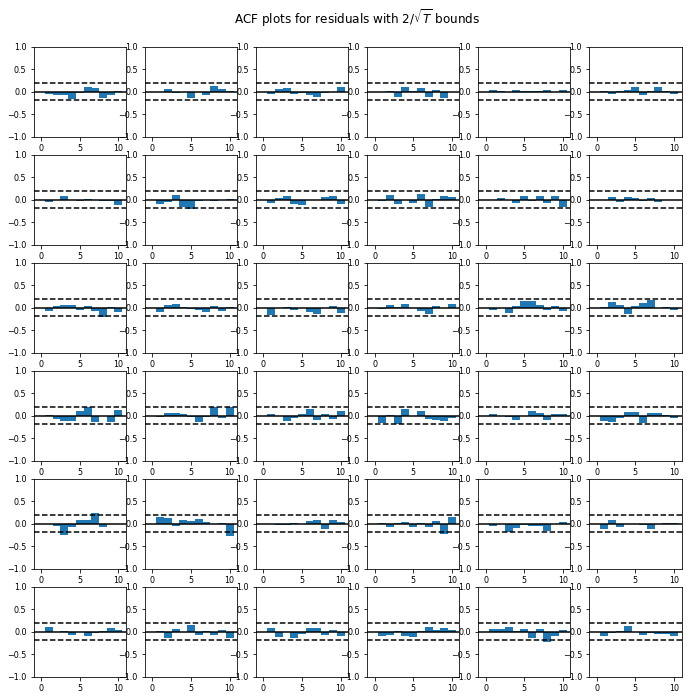

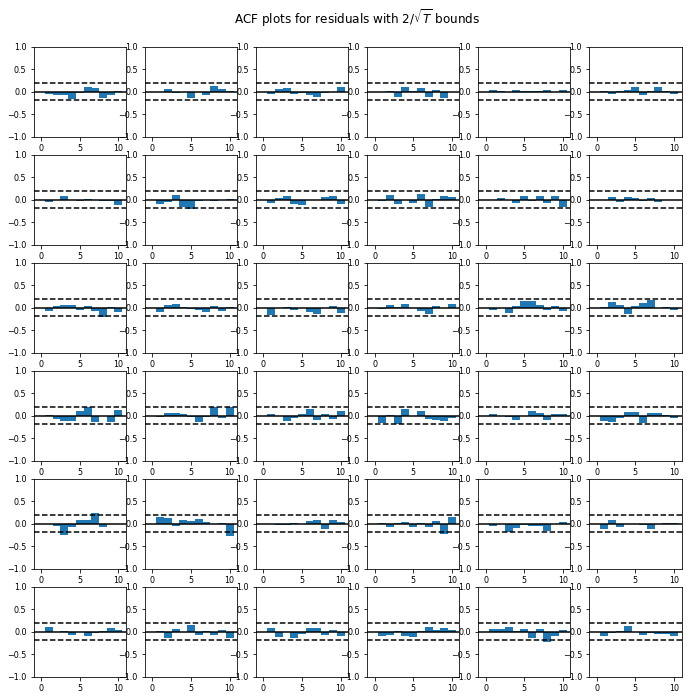

In [15]:
######### STABILITY RESIDUALS AUTOCORRELATION #########
model_fit.plot_acorr()

#if residuals out of range -> unstable model 

In [16]:
######### GRANGER CAUSALITY TEST #########
#for gas price
GrangerCausality = model_fit.test_causality('price_gas', ['gbpusd'], kind='f')
print(GrangerCausality.summary())

#granger causality test : HO not rejected => there is some causality between the variables

#importance of the order: if p value higher, does it mean that one variable is generating the other ?

Granger causality F-test. H_0: gbpusd does not Granger-cause price_gas. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.9945          1.799   0.455 (12, 210)
-----------------------------------------------


FEVD for price_gas
      price_gas  price_brent_gbp  coal_gbp  open_interest_gas_cycle      euas    gbpusd
0      1.000000         0.000000  0.000000                 0.000000  0.000000  0.000000
1      0.888933         0.027422  0.030987                 0.018146  0.034224  0.000288
2      0.821647         0.036849  0.049279                 0.039882  0.052133  0.000210
3      0.774816         0.044089  0.054999                 0.075723  0.047444  0.002929
4      0.746610         0.070180  0.055336                 0.079798  0.040678  0.007398
5      0.725113         0.098014  0.049678                 0.075037  0.036674  0.015484
6      0.698829         0.123956  0.047311                 0.072734  0.035501  0.021669
7      0.682370         0.139394  0.046407                 0.070650  0.039852  0.021326
8      0.665508         0.134196  0.045901                 0.079624  0.046829  0.027942
9      0.661718         0.120603  0.042331                 0.072029  0.068750  0.034568
10     0.6410

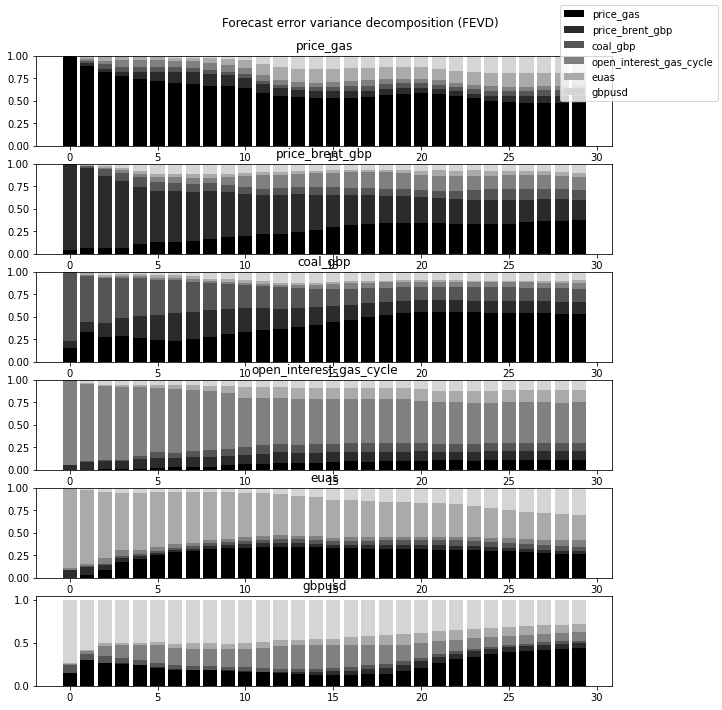

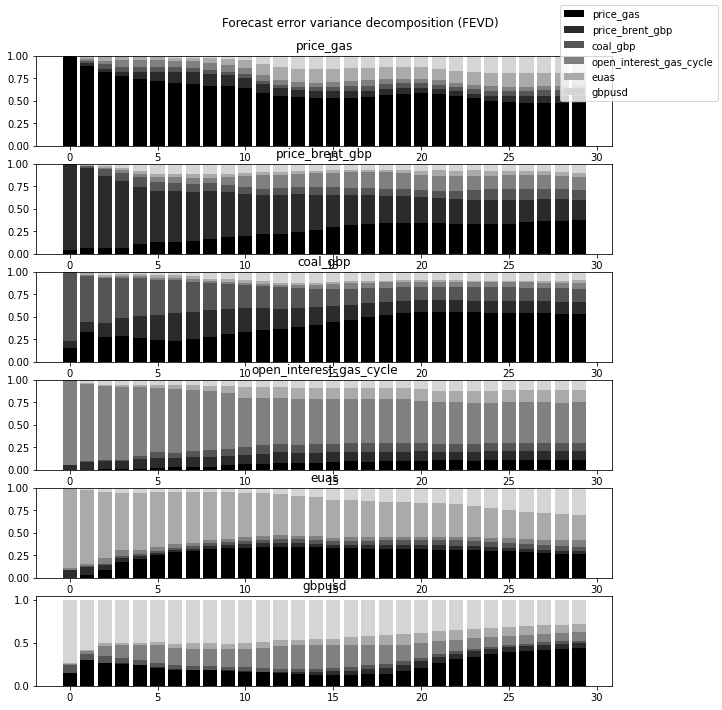

In [17]:
######### FORECAST VARIANCE ERROR DECOMPOSITION: #########

#only for 20 periods
n=30
fevd = model_fit.fevd(n)
fevd.summary()


#affichage pour n périodes
model_fit.fevd(n).plot()

IMPULSE RESPONSE ANALYSIS:

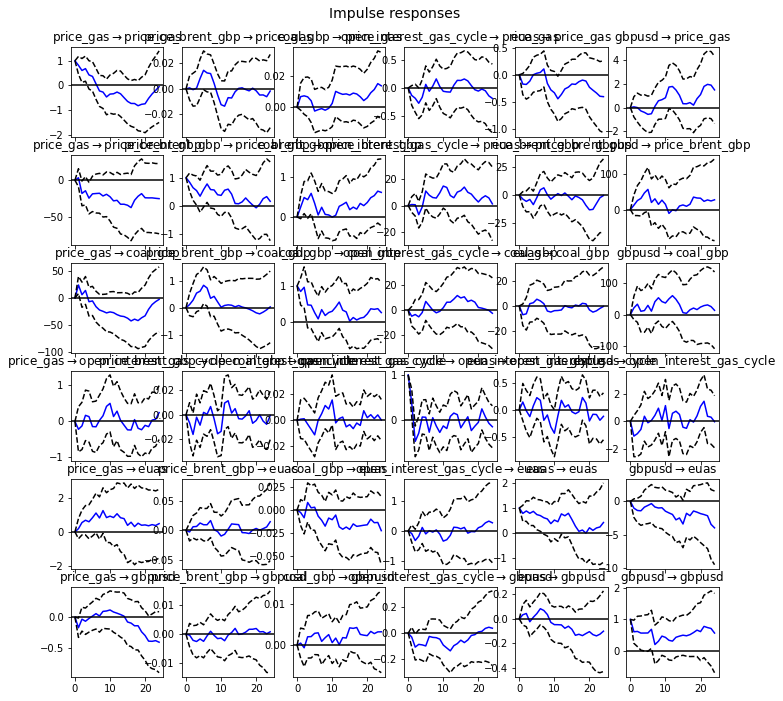

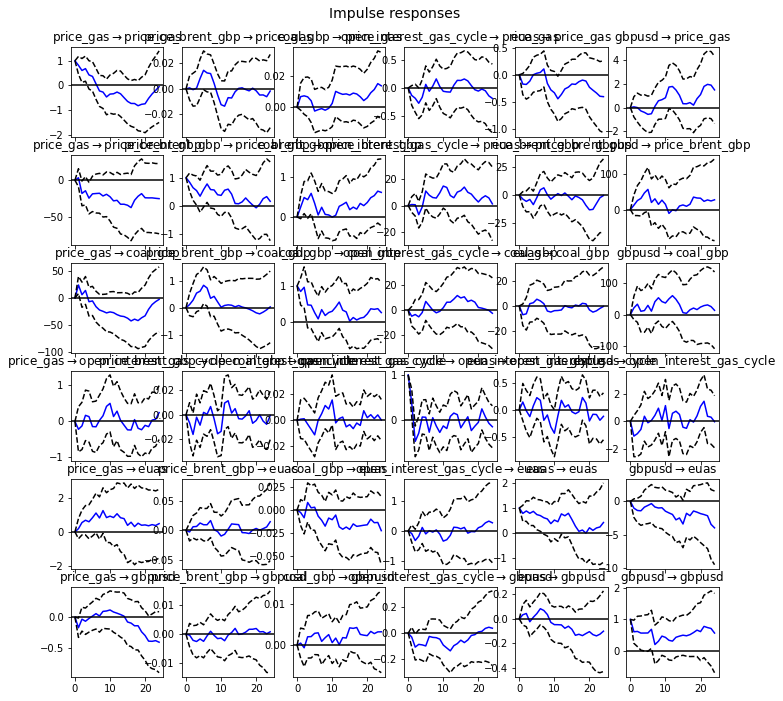

In [18]:
irf = model_fit.irf(24)
irf.plot()

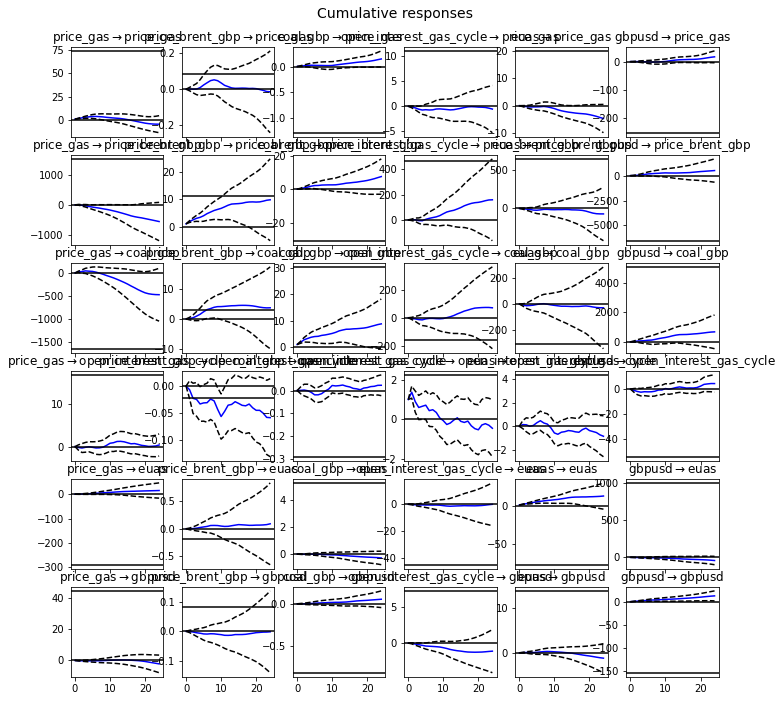

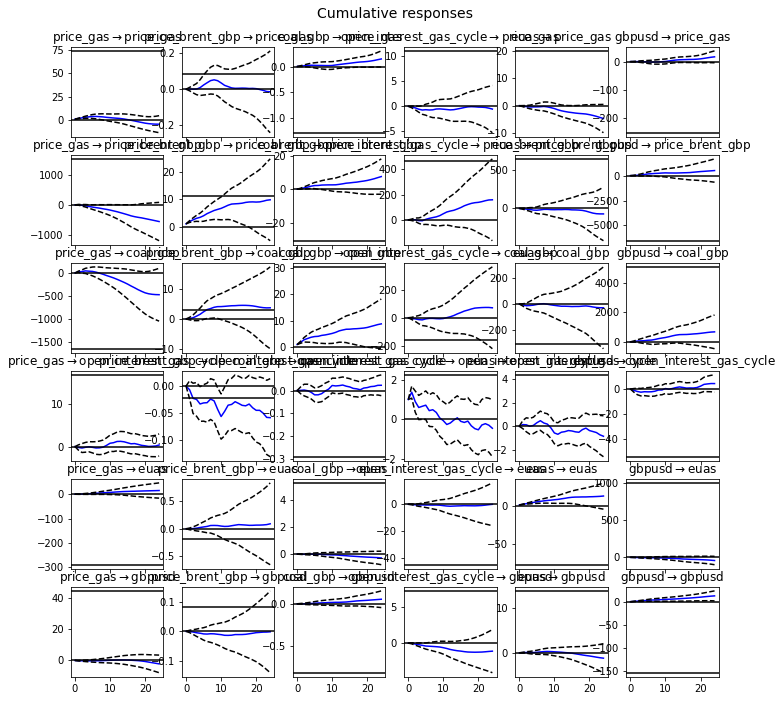

In [19]:
irf.plot_cum_effects(orth=False)

OTHER MODELS

In [20]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_corr['price_gas'], order=(0, 3, 3)) 
results_ARIMA = model.fit()

results_ARIMA.summary()
#results_ARIMA.forecast(3)[0]


#results_ARIMA.plot_predict(start=20)
#plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              price_gas   No. Observations:                  120
Model:                 ARIMA(0, 3, 3)   Log Likelihood                  95.712
Date:                Sun, 24 Jul 2022   AIC                           -183.423
Time:                        17:04:51   BIC                           -172.375
Sample:                             0   HQIC                          -178.938
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.7011      0.116    -14.718      0.000      -1.928      -1.475
ma.L2          0.4238      0.176      2.411      0.016       0.079       0.768
ma.L3          0.2793      0.087      3.200      0.001       0.108       0.450
sigma2         0.0103      0.001      7.218      0.000       0.007       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 1.40
Prob(Q):                              0.74   Prob(JB):                         0.50
Heteroskedasticity (H):               1.29   Skew:                             0.01
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""